# CSC2042S 2025 Assignment 1: Unsupervised Learning
### Maryam Abrahams
### ABRMAR043
### 18th August 2025

## Part 1:  data preprocessing

Conducting exploratory analysis and visualising data using t-SNE dimensionality reduction and the scikit-learn toolbox. Part and parcel of this analysis is the proper documentation alongside it, including justifications, characteristics, and the impact of each preprocessing decision.

T-SNE (t-distributed stochastic neighbour embedding ) takes a high-dimensional dataset and reduces it to a low-dimensional graph, which retains a lot of the data. It does so largely through clustering and maintaining variance, similar to the process of Principal Component Analysis.

In [39]:
# imports, setup, and understanding our data

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("WDICSV.csv")
display(df.head())

# To preprocess the data, we want to take this high-dimensional dataset and reduce it to a low-dimensional one

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,18.001597,18.558234,19.043572,19.586457,20.192064,20.828814,21.372164,22.100884,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.096003,7.406706,7.666648,8.020952,8.403358,8.718306,9.097176,9.473374,NaN,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,38.488233,38.779953,39.068462,39.445526,39.818645,40.276374,40.687817,41.211606,NaN,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,33.922276,38.859598,40.223744,43.035073,44.390861,46.282371,48.127211,48.801258,50.668330,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,16.527554,24.627753,25.432092,27.061929,29.154282,31.022083,32.809138,33.783960,35.375216,NaN


To perform t-SNE on our dataset, we must first reshape the data in such a way that t-SNE will be effective, removing missing features and very incomplete country years so that we don't have such a massive amount of missing data as well as reshaping the data to be better for clustering:

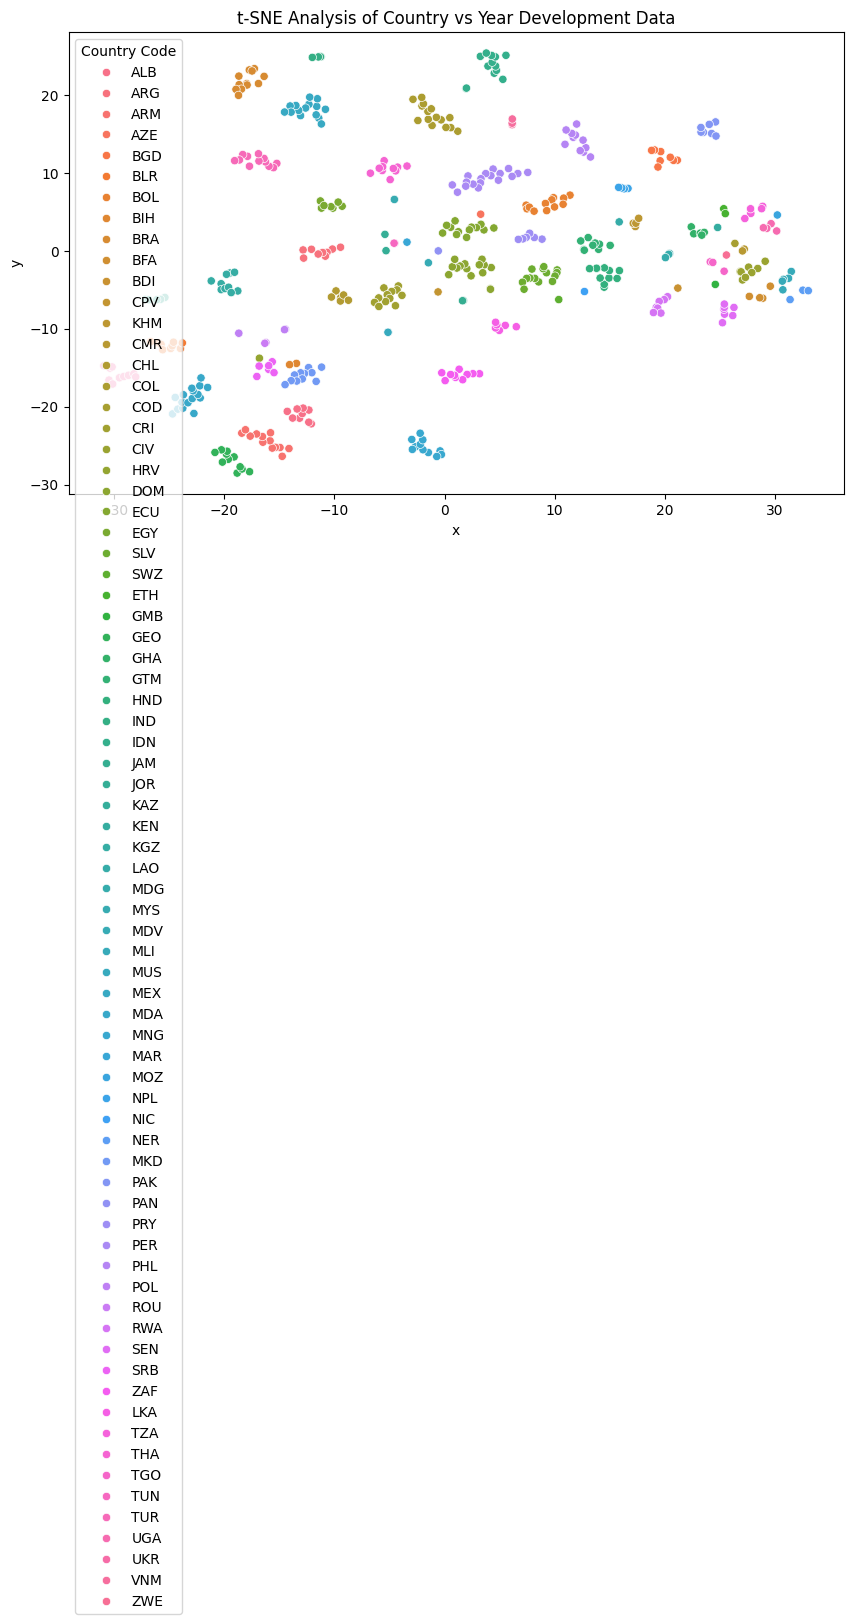

In [40]:
# Reshaping so that there's (Country-year) rows

df_long = df.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
    var_name = 'Year', 
    value_name = 'Value'
)


df_wide = df_long.pivot_table(
    index = ['Country Name', 'Country Code', 'Year'],
    columns = 'Indicator Code', 
    values = 'Value'
).reset_index()

# Cleaning the missing data
numeric_pt = df_wide.drop(['Country Name', 'Country Code', 'Year'], axis=1).notna().mean(axis=1) >= 0.7
df_wide = df_wide[numeric_pt]

features = df_wide.drop(['Country Name', 'Country Code', 'Year'], axis=1)
features = features.fillna(features.mean())

# first I must drop entirely empty rows 
features = features.dropna(axis=1, how='all')


# Conducting t-SNE dimensionality reduction on our dataframe
# resources used: https://youtu.be/85XaciPBCkw

# Scaling features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

m = TSNE(n_components=2, learning_rate = 50)
tsne_features = m.fit_transform(features_scaled)

df_wide['x'] = tsne_features[:,0]
df_wide['y'] = tsne_features[:,1]

# Ordering countries by value instead of numerically
#country_order = df_wide.groupby('Indicator Code')['x'].mean().sort_values().index

plt.figure(figsize=(10,6))
sns.scatterplot(x='x', y ='y', hue='Country Code', data = df_wide)
plt.title("t-SNE Analysis of Country vs Year Development Data")
plt.show()

## Part 2: K-means clustering; Initialization

Selecting k initial centroids randomly from the dataset, where k is the number of clusters you want to find. We want to only use numpy data structures for our K-means clustering implementation.

In [41]:
# Using the K-means clustering tutorial memo as a guideline: 
# Setup: 
import random
import numpy as np

def initialise_centroids(X, k):
    # Choose k unique random indices
    indices = random.sample(range(len(X)), k)
    return [X[i] for i in indices]
    
def compute_cluster_mean(cluster_list):
    #For null values
    if len(cluster_list) == 0:
        return None 
    return np.mean(cluster_list, axis=0)

def compute_euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

def form_new_clusters(X, centroids):
    clusters = [[] for _ in centroids]
    for x in X:
        centroid_distances = [compute_euclidean_distance(x, c) for c in centroids]
        new_cluster = np.argmin(centroid_distances)
        clusters[new_cluster].append(x)
    return clusters

def compute_new_centroids(cluster_list):
    centroids = []
    for cluster_data in cluster_list:
        new_centroid = compute_cluster_mean(cluster_data)
        centroids.append(new_centroid)
    return centroids

def repeat_until_convergence(X, cluster_list, centroids):
    centroid_diff = 10000
    count = 0 #keeping track of the number of iterations
    while centroid_diff > 0:
        new_cluster_list = form_new_clusters(X, centroids)
        new_centroids = compute_new_centroids(new_cluster_list)
        centroid_diff = max([compute_euclidean_distance(centroids[i], new_centroids[i]) for i in range(len(centroids))])
        centroids = new_centroids
        cluster_list = new_cluster_list
        print(centroid_diff)
        count += 1
    return cluster_list, centroids, count

After this setup we now want to implement and compare multiple initialization strategies to understand the effects that differing initializaton will have on the end clustering result. We want to implement both random initialization, using multiple different random seeds and running his test multiple times, as well as K-means ++ initialization, selecting initial centres that are very far apart.

In [29]:
# Random Initialization:

X = features_scaled
k = 10 

# For different seeds:

for seed in [1,2, 3, 4, 5]:
    np.random.seed(seed)
    random.seed(seed)
    print("Iterations:\n")
    centroids = initialise_centroids(X, k)
    cluster_list = form_new_clusters(X, centroids)
    final_clusters, final_centroids, iterations = repeat_until_convergence(X, cluster_list, centroids)
    
    print()
    if iterations > 1 and iterations != 0: 
        print("It took " + str(iterations) + " iterations for the algorithm to converge with random initialization.")
    else: 
        print("It took " + str(iterations) + " iteration for the algorithm to converge with random initialization.")

Iterations:

37.81006404523605
10.942066060812326
4.983971652934839
2.3487933980861104
4.015966987718303
5.801499793084254
11.984153685149678
12.404353545700532
10.517982479963202
2.9160175699108533
0.0

It took 11 iterations for the algorithm to converge with random initialization.
Iterations:

30.607542637827624
8.409341447005758
19.07204274917192
5.350987472209934
6.1181924912844625
5.066200012057751
8.138117611138478
15.938047022441197
2.9160175699108533
0.662515267528377
0.0

It took 11 iterations for the algorithm to converge with random initialization.
Iterations:

40.885978428167
14.580505104571632
5.0131947276669315
4.88721709904035
8.449806436006831
1.504916497308088
1.5244531900748464
1.7002496437602053
2.2211198283492677
1.8737640438339602
2.4812010376390297
0.9155721143396652
1.0492062247223861
1.4248042376345331
0.5215308572172803
0.0

It took 16 iterations for the algorithm to converge with random initialization.
Iterations:

35.03527910398298
18.972918278538582
12.66169

In [43]:
# Initialization via K-means++

def k_means_plus_plus(X,k):
    n_samples = X.shape[0]
    centroids = []
    c_one = np.random.randint(0, n_samples) 
    centroids.append(X[c_one])

    for i in range(1,k):  
        distances = np.array([min(np.linalg.norm(x-c)**2 for c in centroids) for x in X])
        probs = distances/distances.sum()
        c_new = np.random.choice(n_samples, p = probs) 
        centroids.append(X[c_new])
        
    return centroids

# Running our K-means++

for seed in [1,2, 3, 4, 5]:
    np.random.seed(seed)
    random.seed(seed)
    print("Iterations:\n")
    centroids = k_means_plus_plus(X, k)
    cluster_list = form_new_clusters(X, centroids)
    final_clusters, final_centroids, iterations = repeat_until_convergence(X, cluster_list, centroids)
    
    loss = sum([sum([np.linalg.norm(x - final_centroids[i])**2 for x in final_clusters[i]]) for i in range(k)])
    loss = round(loss, 2)
                 
    print()
    if iterations > 1: 
        print("It took " + str(iterations) + " iterations for the algorithm to converge with k-means++, With a final loss of " + str(loss))
    else: 
        print("It took " + str(iterations) + " iteration for the algorithm to converge with random k_means++, With a final loss of " + str(loss))

Iterations:

48.00497711422638
14.132377423333818
8.855155406144885
7.475020223252444
0.8265648484777801
0.0

It took 6 iterations for the algorithm to converge with k-means++, With a final loss of 467057.02
Iterations:

31.919246287830163
10.514029635415616
12.25914826680471
7.039327275543369
4.8217566636194285
3.0077886156692304
3.833978008706215
0.5198517111499814
0.0

It took 9 iterations for the algorithm to converge with k-means++, With a final loss of 447321.2
Iterations:

35.52585004859378
20.503837516868494
18.482263271923973
37.01691661581763
8.472799375258356
6.372777931784498
19.10061504017041
3.3818456212903847
0.46441584949490594
0.0

It took 10 iterations for the algorithm to converge with k-means++, With a final loss of 428614.49
Iterations:

34.433641304872395
8.898838275964001
8.416524640825516
3.656772337011412
1.9126978289610885
0.0

It took 6 iterations for the algorithm to converge with k-means++, With a final loss of 474354.82
Iterations:

32.32290618879702
9.199

### Cluster Analysis: 
Visualizing the cluster centroids for each cluster in both the random and k-means++ initialization cases

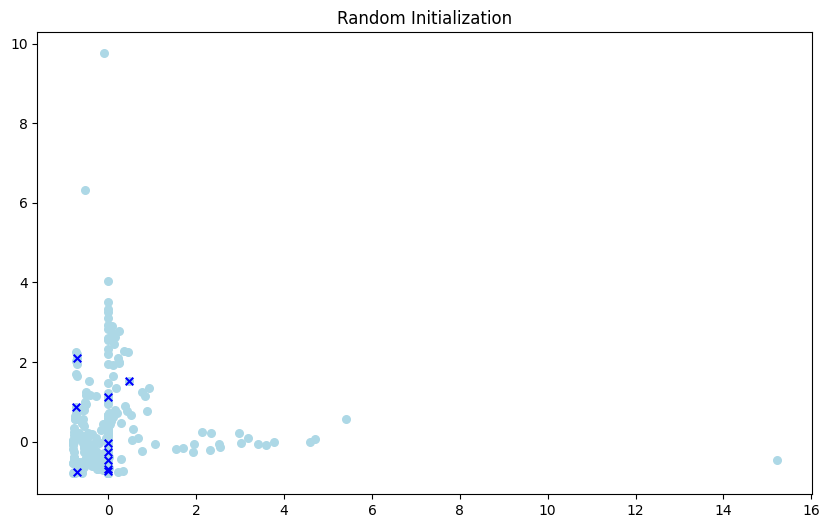

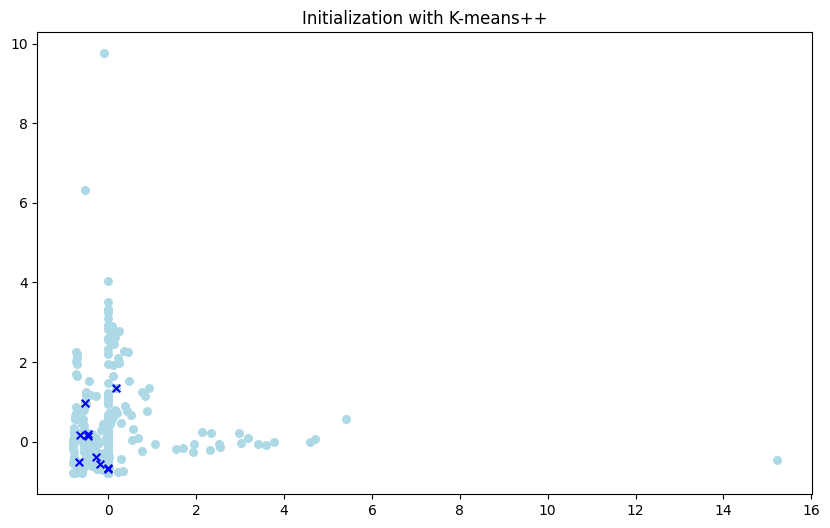

In [56]:
# Visualizing the final centroids
def plot_initial(X, centroids, title):
    centroids = np.array(centroids)
    plt.figure(figsize=(10,6))
    plt.scatter(X[:, 0], X[:,1], s=30, c="lightblue", label="Data")
    plt.scatter(centroids[:, 0], centroids[:, 1], c="blue", s=30, marker="x", label="Centroids")
    plt.title(title)
    plt.show()

c_random = initialise_centroids(X, k)
c_kmeans = k_means_plus_plus(X, k) 
plot_initial(X, c_random, "Random Initialization")
plot_initial(X, c_kmeans, "Initialization with K-means++")


## Part 2: K-means clustering; Initialization

Selecting k initial centroids randomly from the dataset, where k is the number of clusters you want to find. We want to only use numpy data structures for our K-means clustering implementation.